In [1]:
from numbers import Real
from typing import Callable
from copy import deepcopy
from collections import deque
import random
import tqdm
from scipy.linalg import solve_discrete_are as dare

import numpy as np
import jax.numpy as jnp
import torch
import torch.nn as nn

from deluca.agents._lqr import LQR
from deluca.agents.core import Agent

In [2]:
def append(arr, val):
    if isinstance(arr, torch.Tensor):
        if not isinstance(val, torch.Tensor):
            val = torch.tensor(val, dtype=arr.dtype)
        arr = torch.roll(arr, -1, dims=(0,)).clone()  # have to do it this way for autograd, but its not slower for some reason
        arr[-1] = val
    elif isinstance(arr, jnp.ndarray):
        if not isinstance(val, jnp.ndarray):
            val = jnp.array(val, dtype=arr.dtype)
        arr = arr.at[0].set(val)
        arr = jnp.roll(arr, -1, axis=0)
    return arr
    

class SystemEstimate:
    
    # FOR NN
    def __init__(self,
                h: int,
                du: int,
                eta: float,
                use_nn: bool=False):
        self.h = h
        self.du = du
        self.use_nn = use_nn
        
        if self.use_nn:  # FOR NN
            f_dim = self.h  # past f's (f_{t-1} to f_{t-h})
            u_dim = self.h * self.du  # past u's (u_t to u_{t-h+1})
            self.flat_dim = f_dim + u_dim  # compute dimension
            self.model = nn.Sequential(nn.Linear(self.flat_dim, 256), 
                                       nn.ReLU(), 
                                       nn.Linear(256, 64), 
                                       nn.ReLU(), 
                                       nn.Linear(64, 10),
                                       nn.ReLU(),
                                       nn.Linear(10, 1)).float().train()
            self.opt = torch.optim.Adam(self.model.parameters(), eta)
            
        else:  # FOR LINEAR REGRESSION
            self.K = torch.nn.Parameter(torch.zeros(self.h, dtype=torch.float32))  # predicts from past f's (f_{t-1} to f_{t-h})
            self.Q = torch.nn.Parameter(torch.zeros((self.h, self.du), dtype=torch.float32))  # predicts from past u's (u_t to u_{t-h+1})
            self.b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32))  # bias

            self.opt = torch.optim.Adam([self.K, self.Q, self.b], eta)
        
        self.experience_buffer = deque(maxlen=10000)
        pass
    
    def forward(self, fs, us):
        assert fs.shape == (self.h,) and us.shape == (self.h, self.du)

        if self.use_nn:
            inp = torch.cat([fs.reshape(-1), us.reshape(-1)], dim=0).unsqueeze(0)
            assert inp.shape[1] == self.flat_dim, 'somethings not right'
            pred = self.model(inp)
        else:
            pred = torch.dot(self.K, fs) + torch.tensordot(self.Q, us) + self.b
        return pred.squeeze()
    
    def experience_replay(self, num_iters: int):
        assert num_iters <= len(self.experience_buffer)
        
        batch = random.sample(self.experience_buffer, num_iters)
        for inp, f in batch:
            self.opt.zero_grad()
            f_hat = self.forward(*inp)
            loss = torch.nn.functional.mse_loss(f_hat, f)
            loss.backward(retain_graph=True)
            self.opt.step()
        pass
        
    
    def step(self, f, fs, us):
#         self.experience_buffer.append(((fs.clone(), us.clone()), f.clone()))

        self.opt.zero_grad()
        f_hat = self.forward(fs, us)
        loss = torch.nn.functional.mse_loss(f_hat, f)
        loss.backward(retain_graph=True)
        self.opt.step()
        
#         num_iters = 100
#         if len(self.experience_buffer) >= num_iters: self.experience_buffer.maxlen: self.experience_replay(num_iters)
        
        return f_hat.item()
    
    def get_stabilizing_controller(self):
        if self.use_nn:
            print('Using nn for regression, so no stabilizing controller can be provided!')
            K = torch.zeros((self.du, self.h))
        else:
            # figure out system of the form x_{t+1} = A @ x_t + B @ u_t, where x_t is the lifted state history and u_t is still the instantaneous control
            A = torch.eye(self.h)
            A[0] = self.K.data
            A = torch.roll(A, -1, dims=(0,))
            B = torch.zeros((self.h, self.du))
            B[-1] = self.Q[-1]
            
            # compute stabilizing controller for squared costs
            Q = torch.zeros((self.h, self.h))
            Q[-1, -1] = 1.
            R = torch.eye(self.du)
            
            A, B, Q, R = A.detach().numpy(), B.detach().numpy(), Q.detach().numpy(), R.detach().numpy()
            X = dare(A, B, Q, R)  # solve the ricatti equation
            K = jnp.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)  # compute LQR gain
        return K
            

In [3]:
"""
THIS TREATS THE COSTS AS THE STATE!!!
"""

class Extravaganza(Agent):
    def __init__(self,
                 sys: SystemEstimate,
                 h: int,  # controller history
                 tau: int,  # system rollout length
                 du: int,  # control dimension
                 eta: float,  # learning rate!
                 K: torch.Tensor=None,  # stabilizing controller (should be of shape (du, sys.h))
                ):
        
        assert h >= sys.h, 'controller memory should be longer than system estimate memory'
        
        self.sys = sys
        self.h = h  # controller history length
        self.tau = tau  # system rollout length
        self.du = du  # control dimension

        # dynamic parameters
        self.M = torch.nn.Parameter(torch.zeros((self.h, self.du), dtype=torch.float32))  # prediction params
        self.bias = torch.nn.Parameter(torch.zeros(self.du, dtype=torch.float32))
        self.K = torch.nn.Parameter(K if K is not None else torch.zeros((self.du, self.sys.h)))
        self.opt = torch.optim.SGD([self.M, self.bias], lr=eta)
        
        # state
        self.ws = torch.zeros(self.h + self.tau, dtype=torch.float32)  # Past h + tau disturbances, rightmost recent (i.e. self.ws[-1] = w_t)
        self.us = torch.zeros((self.sys.h + self.tau, self.du), dtype=torch.float32)  # past h + tau controls, rightmost recent
        self.fs = torch.zeros(self.sys.h + self.tau, dtype=torch.float32)  # past h + tau costs, rightmost recent
        self.t = 1  # time counter
        
        
    def rollout(self):
        """
        Surrogate cost function with current parameters.
        Uses actual observed disturbances, controls predicted by the controller, and costs assigned 
        by the system estimate.
        """
        with torch.no_grad():
            # get local state for timestep `t - tau`
            us = self.us[:-self.tau]  # this equals (u_{t-tau-h+1}, ..., u_{t-tau})
            fs = self.fs[:-self.tau]
            t = self.t - self.tau
        
        # do the rollout from starting state `t - tau` to `t`
        for i in range(self.tau):
            u = -self.K @ fs + (self.M * self.ws[i: i + self.h].reshape(-1, 1)).sum(dim=0) + self.bias
            us = append(us, u)
            f = self.sys.forward(fs, us) + self.ws[i + self.h]
            fs = append(fs, f)
            t += 1
         
        if not COST_STATES: f = cost_fn(f, self.get_control(f))
        return f
            

    def __call__(self, cost: float) -> torch.Tensor:
        """
        Returns the control based on current cost and internal parameters.
        """
        if not isinstance(cost, torch.Tensor): cost = torch.tensor(cost)
        
        control = self.get_control(cost)
        self.update(cost, control)
        return control
    

    def update(self, cost, control) -> None:
        """
        here, control is the control to play !after! receiving the cost
        """
        # compute new disturbance
        pred = self.sys.step(cost, self.fs[self.tau:], self.us[self.tau:])
        w = cost - pred
#         print(self.t, cost, pred, w)
#         w = w.clamp(-1, 1)
        
        # if it's time, adopt the stabilizing controller
        if self.t == K_TIME:
            self.K.data = torch.tensor(np.array(self.sys.get_stabilizing_controller()).copy())
            self.opt.add_param_group({'params': self.K})
            self.opt.param_groups[1]['lr'] = self.opt.param_groups[0]['lr']
            try: self.opt.param_groups[1]['momentum'] = self.opt.param_groups[0]['momentum']
            except: pass
    
        if self.t > WAIT and self.t % STEP_EVERY == 0:
            # update controller parameters via rollout
            self.opt.zero_grad()
            r = self.rollout()
            r.backward()
            self.opt.step()
            
        # for logging
        self._grad = self.M.grad.data.clone() if self.M.grad is not None else torch.zeros_like(self.M)
            
        with torch.no_grad():
            # update controller state
            self.ws = append(self.ws, w)
            self.us = append(self.us, control)
            self.fs = append(self.fs, cost)
            self.t += 1
        pass


    def get_control(self, cost: float) -> torch.Tensor:
        if self.t > WAIT:
            pred = -self.K @ self.fs[self.tau:] + (self.M * self.ws[-self.h:].reshape(-1, 1)).sum(dim=0) + self.bias
        else:
            pred = torch.randn(self.du)  # explore randomly during pure sysid
        return pred

In [4]:
class System:
    """
    SYSTEM STATE DEPENDS ON PAST H STATES AND MOST RECENT CONTROL!!!!
    """
    def __init__(self, h, control_dim):
        self.h = h
        self.control_dim = control_dim
        
        self.A = torch.eye(self.h)
        self.A[0] = torch.randn(h)
        self.A = torch.roll(self.A, -1, dims=(0,))
        self.B = torch.zeros((self.h, control_dim))
        self.B[-1] = torch.randn(control_dim)
        
        self.s = torch.zeros(h)
        
    def step(self, control, disturbance):
        if not isinstance(control, torch.Tensor):
            control = torch.from_numpy(np.array(control))
#         print('true state', self.s, 'true control', control, 'true next state', self.A @ self.s + self.B @ control)
        self.s = self.A @ self.s + self.B @ control + disturbance * torch.nn.functional.one_hot(torch.tensor(self.h - 1))
        return self.s
    pass
  
def cost_fn(x, u):
    cost = x ** 2 #+ (u * u).sum()
    if isinstance(cost, float):
        cost = torch.tensor(cost)
    return cost

def disturbance(t):
#     return np.sin(4 * 2 * np.pi * t / T)
#     return t
    return 1
#     return np.random.randn()
#     return 0

LQR


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 7203.37it/s]


GROUND TRUTH


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 175.36it/s]


tensor([ 0.3923, -0.2236, -0.3195]) tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-1.2050,  1.0445]]) tensor([0.])
LINEAR


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 187.34it/s]


tensor([0.1557, 0.1576, 0.1635]) tensor([[ 0.0033, -0.0034],
        [ 0.0080, -0.0038],
        [-0.0028,  0.0055]]) tensor([0.1922])
COSTS ONLY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1010.81it/s]


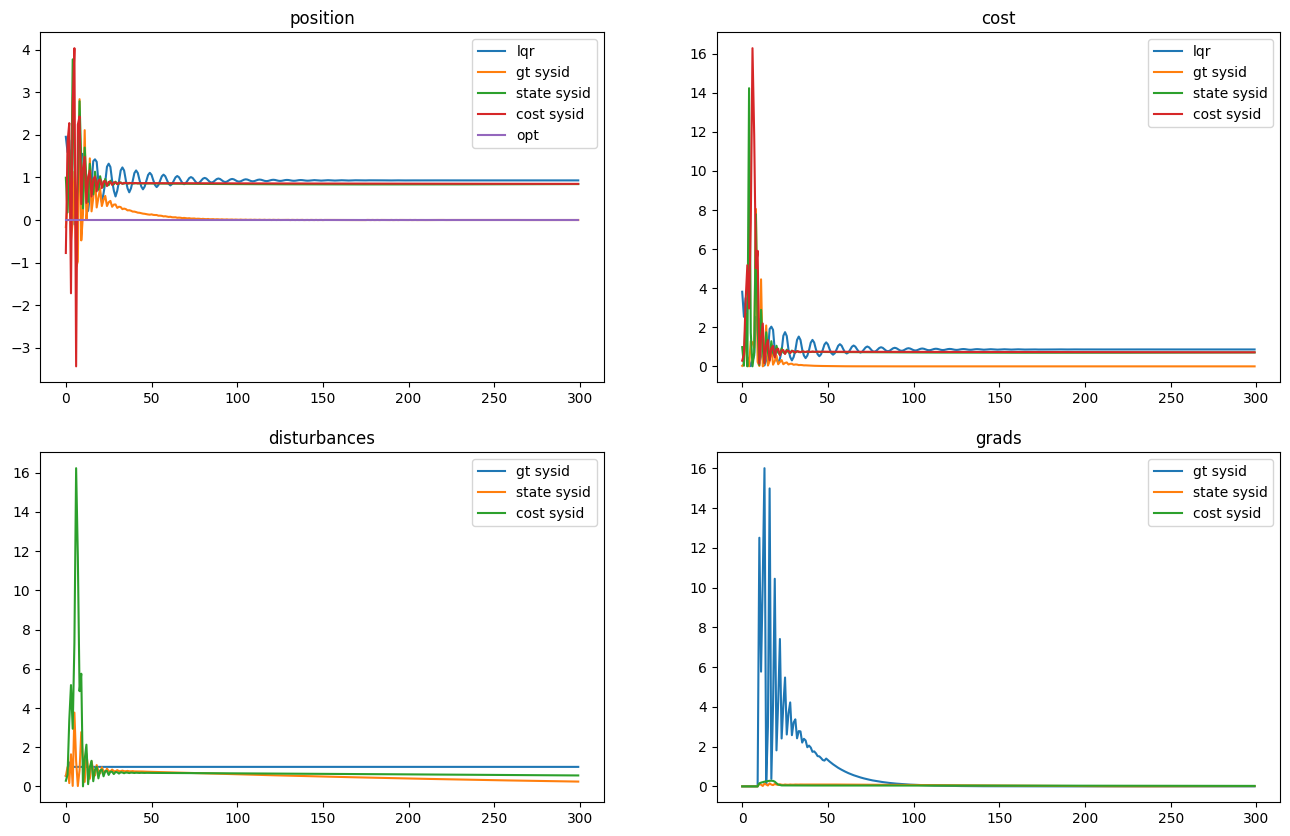

In [5]:
SYS_ESTIMATION_LR = 0.001
CONTROLLER_LR = 0.001

SEED = 2
state_h = 3  # lifted state dim
du = 2
controller_h = 10  # controller memory length (# of w's to use on inference)
tau = 4
T = 300

K_TIME = 50
WAIT = controller_h
STEP_EVERY = 1

torch.manual_seed(SEED)
sys_init = System(h=state_h, control_dim=du)
sys_init.s = torch.randn(state_h)  # initial state history

# --------------- LQR ------------------------------------------------------

Q = jnp.zeros((state_h, state_h)).at[-1, -1].set(1.)
R = np.identity(du) * 1e-8

sys = deepcopy(sys_init)
lqr = LQR(A=sys.A.numpy(), B=sys.B.numpy(), Q=Q, R=R)
x = sys.s.clone()

xs_lqr = []
costs_lqr = []
print('LQR')
for t in tqdm.trange(T):
    control = lqr(x.numpy())
    x = sys.step(control, disturbance(t)) 
    xs_lqr.append(x[-1])
    costs_lqr.append(cost_fn(x[-1].item(), control).item())
    
# --------------- EXTRAVAGANZA_GT ------------------------------------------------------

e = Extravaganza(SystemEstimate(state_h, du, SYS_ESTIMATION_LR, use_nn=False), controller_h, tau, du, CONTROLLER_LR)
sys = deepcopy(sys_init)
x = sys.s.clone()

# make sure we have the right sysid
COST_STATES = False
e.sys.K.data = sys.A[-1].clone().reshape(-1)
e.sys.Q.data[-1] = sys.B[-1]
e.sys.b.data.zero_()
e.sys.opt.param_groups[0]['lr'] = 0.
xs_extravaganza_gt = []
costs_extravaganza_gt = []
ws_extravaganza_gt = []
grads_extravaganza_gt = []
print('GROUND TRUTH')
for t in tqdm.trange(T):
    control = e(x[-1])
    x = sys.step(control, disturbance(t))
    xs_extravaganza_gt.append(x[-1].item())
    costs_extravaganza_gt.append(cost_fn(x[-1], control).item())
    ws_extravaganza_gt.append(e.ws[-1])
    grads_extravaganza_gt.append(torch.norm(e._grad).item())
print(e.sys.K.data, e.sys.Q.data, e.sys.b.data)

# # ----------------- EXTRAVAGANZA_LINEAR --------------------------------------------------
    
e = Extravaganza(SystemEstimate(state_h, du, SYS_ESTIMATION_LR, use_nn=False), controller_h, tau, du, CONTROLLER_LR)
sys = deepcopy(sys_init)
x = sys.s.clone()

# make sure we have the right sysid
COST_STATES = False
xs_extravaganza_linear = []
costs_extravaganza_linear = []
ws_extravaganza_linear = []
grads_extravaganza_linear = []
print('LINEAR')
for t in tqdm.trange(T):
    control = e(x[-1])
    x = sys.step(control, disturbance(t))
    xs_extravaganza_linear.append(x[-1].item())
    costs_extravaganza_linear.append(cost_fn(x[-1], control).item())
    ws_extravaganza_linear.append(e.ws[-1])
    grads_extravaganza_linear.append(torch.norm(e._grad).item())
print(e.sys.K.data, e.sys.Q.data, e.sys.b.data)

# ----------------- EXTRAVAGANZA_COSTS --------------------------------------------------
    
e = Extravaganza(SystemEstimate(state_h, du, SYS_ESTIMATION_LR, use_nn=False), controller_h, tau, du, CONTROLLER_LR)
sys = deepcopy(sys_init)
x = sys.s.clone()

COST_STATES = True
xs_extravaganza_costs = []
costs_extravaganza_costs = []
ws_extravaganza_costs = []
grads_extravaganza_costs = []
print('COSTS ONLY')
# print(e.sys.model)
for t in tqdm.trange(T):  # disturbance on the state
    cost = cost_fn(x[-1], control).item()
    control = e(cost)
    x = sys.step(control, disturbance(t))
    xs_extravaganza_costs.append(x[-1].item())
    costs_extravaganza_costs.append(cost)
    ws_extravaganza_costs.append(e.ws[-1])
    grads_extravaganza_costs.append(torch.norm(e._grad).item())

# for t in tqdm.trange(T):  # disturbance on the cost
#     w = disturbance(t)
#     cost = cost_fn(x[-1], control).item() + w
#     control = e(cost)
#     x = sys.step(control, 0)
#     xs_extravaganza_costs.append(x[-1].item())
#     costs_extravaganza_costs.append(cost - w)
#     ws_extravaganza_costs.append(e.ws[-1])
#     grads_extravaganza_costs.append(torch.norm(e._grad).item())
    

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# plot lqr
ax[0, 0].plot(range(T), xs_lqr, label='lqr')
ax[0, 1].plot(range(T), costs_lqr, label='lqr')

# plot gt
ax[0, 0].plot(range(T), xs_extravaganza_gt, label='gt sysid')
ax[0, 1].plot(range(T), costs_extravaganza_gt, label='gt sysid')
ax[1, 0].plot(range(T), ws_extravaganza_gt, label='gt sysid')
ax[1, 1].plot(range(T), grads_extravaganza_gt, label='gt sysid')

# plot linear
ax[0, 0].plot(range(T), xs_extravaganza_linear, label='state sysid')
ax[0, 1].plot(range(T), costs_extravaganza_linear, label='state sysid')
ax[1, 0].plot(range(T), ws_extravaganza_linear, label='state sysid')
ax[1, 1].plot(range(T), grads_extravaganza_linear, label='state sysid')

# plot costs
ax[0, 0].plot(range(T), xs_extravaganza_costs, label='cost sysid')
ax[0, 1].plot(range(T), costs_extravaganza_costs, label='cost sysid')
ax[1, 0].plot(range(T), ws_extravaganza_costs, label='cost sysid')
ax[1, 1].plot(range(T), grads_extravaganza_costs, label='cost sysid')

ax[0, 0].plot(range(T), [0. for _ in range(T)], label='opt')
ax[0, 0].set_title('position'); ax[0, 0].legend()
ax[0, 1].set_title('cost'); ax[0, 1].legend()
ax[1, 0].set_title('disturbances'); ax[1, 0].legend()
ax[1, 1].set_title('grads'); ax[1, 1].legend()

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.46it/s]


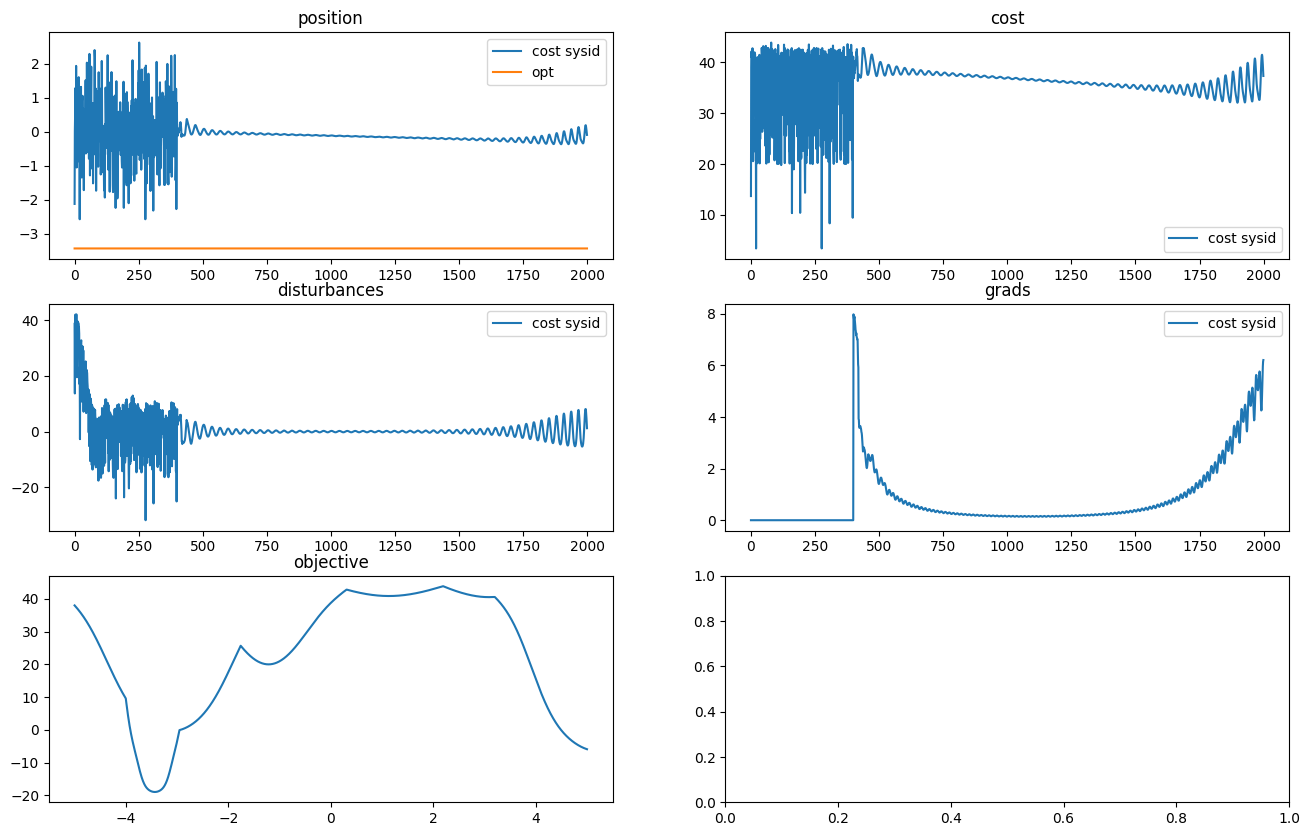

In [6]:
from dynamical_systems import COCO

SYS_ESTIMATION_LR = 0.001
CONTROLLER_LR = 0.001

du = 1
state_h = 20
controller_h = 20  # controller memory length (# of w's to use on inference)
tau = 3
T = 2000

K_TIME = 4000
WAIT = 400
STEP_EVERY = 1

e = Extravaganza(SystemEstimate(state_h, du, SYS_ESTIMATION_LR, use_nn=False), controller_h, tau, du, CONTROLLER_LR)
sys = COCO(index=683, u_index=0, predict_differences=False)

cost = sys.interact(0.)

COST_STATES = True
xs = []
costs = []
ws = []
grads = []
for t in tqdm.trange(T):
    control = e(cost)
    cost = sys.interact(control)
    xs.append(sys.x[sys.u_index])
    costs.append(cost)
    ws.append(e.ws[-1])
    grads.append(torch.norm(e._grad).item())
    

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(16, 10))

# plot 
ax[0, 0].plot(range(T), xs, label='cost sysid')
ax[0, 1].plot(range(T), costs, label='cost sysid')
ax[1, 0].plot(range(T), ws, label='cost sysid')
ax[1, 1].plot(range(T), grads, label='cost sysid')

ax[0, 0].plot(range(T), [sys.stats['optimal_control']['value'] for _ in range(T)], label='opt')
ax[0, 0].set_title('position'); ax[0, 0].legend()
ax[0, 1].set_title('cost'); ax[0, 1].legend()
ax[1, 0].set_title('disturbances'); ax[1, 0].legend()
ax[1, 1].set_title('grads'); ax[1, 1].legend()

us, fs = sys.stats['gt_controls']['value'], sys.stats['gt_values']['value']
ax[2, 0].plot(us, fs)
ax[2, 0].set_title('objective')

plt.show()